## Train an agent to play tic tac toe

### Strategies
1. Play at random
2. Ideal Player
3. Imitation learning


In [1]:
import itertools
import random
import time

In [241]:
DEBUG = False
def log(s):
    if DEBUG: print(s)


In [231]:
COMPUTER = False
HUMAN = True

class Player():
    HUMAN = 0
    RANDOM = 1
    EXPERT = 2
    STUDENT = 3
    
    def __init__(self, player, symbol):
        if (player == Player.HUMAN
                or player == Player.RANDOM
                or player == Player.EXPERT
                or player == Player.STUDENT):
            self.ptype = player
            self.name = Player.get_player_str(player)
            self.symbol = symbol
        else:
            raise ValueError(f'{player} is not a valid Player identifier.')
            
    def __str__(self):
        return f'ptype: {self.ptype}, name: {self.name}, symb: {self.symbol}'
    
    def set_model(self, model):
        """
        set a neural net model
        """
        if self.ptype==Player.STUDENT:
            self.model = model
        else:
            raise ValueError(f'cannot assign model to non STUDENT Player.')

    @staticmethod
    def get_player_str(player):
        if player == Player.HUMAN:
            return 'HUMAN'
        elif player == Player.RANDOM:
            return 'COMP-RANDOM'
        elif player == Player.EXPERT:
            return 'COMP-EXPERT'
        elif player == Player.STUDENT:
            return 'COMP-STUDENT'


class Entry():
    Empty = '-'
    X = 'X'
    O = 'O'
    

In [234]:


class TicTacToe():
    """
    define the game class
    COMPUTER always plays an 'O'
    HUMAN always plays a 'X'
    """
    
    MNMX_MOVES = 0
    TURNS = 0
    
    def __init__(self, player_1, player_2):
        """
        initialize the board
        """
        if(player_1 == player_2) :
            print("ERROR: same players not supported right now")
            assert(player_1 != player_2)
            return 
        self.state = ['-'] * 9
        self.turn = random.choice([player_1, player_2])
        self.game_ended = False
        self.winner = '-'
        self.player_1 = player_1
        self.player_2 = player_2
        self.prev_state = self.state
        self.last_played = -1
        
    def reset(self):
        self.state = ['-'] * 9
        self.turn = random.choice([self.player_1, self.player_2])
        self.game_ended = False
        self.winner = '-'
        self.prev_state = self.state
        self.cur_state = self.state
        self.last_played = -1
        
    def _switch_turn(self):
        self.turn = self._get_opponent(self.turn)
            
    def _get_opponent(self, player):
        if player == self.player_1:
            return self.player_2
        else:
            return self.player_1
     
    def __str__(self):
        x = self.pretty_state(self.state)
        return (f'board state: \n{x}\n' +
                f'player turn: {self.turn}\n' +
                f'game ended: {self.game_ended}\n' +
                f'winner: {self.winner}\n')
    
    def pretty_state(self, state):
        x = str(state[0:3]) + '\n' + \
            str(state[3:6]) + '\n' + \
            str(state[6:9])
        return x
    
    def play(self):
        self.prev_state = self.state.copy()
        self.TURNS += 1
        log(f'TURN no: {self.TURNS}')
        log('play a turn')
        log(f'turn: {self.turn}')
        if self.game_ended:
            log('Game Over')
            log(self)
            return
        avail_positions = []
        for i, x in enumerate(self.state):
            if x == Entry.Empty: avail_positions.append(i)
        if len(avail_positions) == 0:
            self.game_ended = True
            self.winner = 'DRAW'
            log('board is full')
            return
        if self.turn.ptype == Player.RANDOM:
            log(f'{self.turn.name} to play')
            log(f'available positions: {avail_positions}')
            play_id = random.choice(avail_positions) 
            log(play_id)
            self.state[play_id] = self.turn.symbol
            self.last_played = play_id
        elif self.turn.ptype == Player.EXPERT:
            play_id = self.play_pro(self.turn)
            self.state[play_id] = self.turn.symbol
            self.last_played = play_id
        elif self.turn.ptype == Player.STUDENT:
            play_id = int(play_student(self.turn.model, self.state))
            self.state[play_id] = self.turn.symbol
            self.last_played = play_id
        elif self.turn.ptype == Player.HUMAN:
            print('HUMAN to play')
            print(f'available positions: {avail_positions}')
            self.user_input_prompt()
            valid_input = False
            while not valid_input:
                inp = input('where do you wanna play [0-9]?')
                if str.isdigit(inp): valid_input = True
                if valid_input:
                    pos = int(inp)
                    if pos not in avail_positions:
                        valid_input = False
                if not valid_input:
                    print('invalid input')
                    print(f'please enter a number from the list: {avail_positions}')
            # got a valid position to play
            self.state[pos] = self.turn.symbol
        
        self.evaluate()
#         self.turn = not self.turn
        self._switch_turn()
        log(self)
#         time.sleep(1)
#         print(f'winner: {self.winner}')
        
    def play_pro(self, player):
        """
        returns the best move by
            play as an expert(pro) using minimax
        `player` object which is playing as pro
        """
        state_copy = self.state.copy()
        self.MNMX_MOVES = 0
        best_move, best_score = self._minimax(state_copy, player)
        log(f'minimax moves taken: {self.MNMX_MOVES}')
        return best_move
        
    def _evaluate(self, state):
        """
        evaluate state, returns game_ended
        """
        rows = [self.state[k:k+3] for k in range(0, 9, 3)]
        cols = [[self.state[k], self.state[k+3], self.state[k+6]]
                 for k in range(0, 3, 1)]
        diags = [[self.state[0], self.state[4], self.state[8]],
                 [self.state[2], self.state[4], self.state[6]]]
        arrs = [rows, cols, diags]
        for arr in itertools.chain(*arrs):
            if (arr[0] != Entry.Empty
                    and arr[0] == arr[1]
                    and arr[0] == arr[2]):
                return True
        return False
        
    def _minimax(self, state, player):
        """
        finds the best move that `player` can play with the 
            given board `state`
        """
        self.MNMX_MOVES += 1
#         print(f'enter mnmx with state:\n{self.pretty_state(state)}')
        empty_pos = self.get_available_pos(state)
        if len(empty_pos) == 0:
            log('no moves available. exiting!')
            log(f'player: {Player.get_player_str(player)}')
        new_state = self.state
        best_score = -100
        best_move = -1
        for pos in empty_pos:
#             print(f'make move: {pos}')
#             if player == COMPUTER: new_state[pos] = Entry.O
#             else: new_state[pos] = Entry.X
            new_state[pos] = player.symbol
            
            if self._evaluate(new_state): # played the winning move
#                 print('winning minimax move')
#                 print(f'player: {player}, state:\n{state}')
#                 return pos, 10
                cur_score = 10
                # try early stopping
                best_score = cur_score
                best_move = pos
                new_state[pos] = Entry.Empty
                break
                # early stop ends
            else:
                cur_score = -100
                if len(empty_pos) == 1: # draw state, last move
                    cur_score = 0
                else:
                    # play more
                    opp = self._get_opponent(player)
                    _, opp_score = self._minimax(new_state, opp)
                    cur_score = -opp_score
            if cur_score > best_score:
                best_score = cur_score
                best_move = pos
            # reset state
            new_state[pos] = Entry.Empty
#             print(f'UNDO move: {pos}')
#         print(f'player: {player}, best_move = {pos}, best_score = {best_score}')
#         print(f'exit mnmx with state:\n{self.pretty_state(state)}')
        return best_move, best_score
        
    def evaluate(self):
        """
        evaluate if there is a winner
        if game ended, update `game_ended` and `winner`
        """
        win = False
        # check rows
        rows = [self.state[k:k+3] for k in range(0, 9, 3)]
        cols = [[self.state[k], self.state[k+3], self.state[k+6]]
                 for k in range(0, 3, 1)]
        diags = [[self.state[0], self.state[4], self.state[8]],
                 [self.state[2], self.state[4], self.state[6]]]
        arrs = [rows, cols, diags]
        for arr in itertools.chain(*arrs):
            if (arr[0] != Entry.Empty
                    and arr[0] == arr[1]
                    and arr[0] == arr[2]):
                win = True
                log(f'winning row: {arr}')
                break
        if win:
            log('we have a winner')
            self.winner = self.turn
#             if self.turn: self.winner = "HUMAN"
#             else: self.winner = "COMPUTER"
            self.game_ended = True
            
    def get_available_pos(self, state):
        avail_positions = []
        for i, x in enumerate(state):
            if x == Entry.Empty: avail_positions.append(i)
        return avail_positions
    
#     def get_state(self):
#         state = 0
#         for i in range(9):
#             s = self.state[i]
#             val = 0
#             if s == Entry.X:
#                 val = 0x3
#             elif s == Entry.O:
#                 val = 0x2
#             state |= val << (i*2)
#         return state
        
    def user_input_prompt(self):
        """
        shows prompt human user to get position to play
        """
        prompt = ''
        for i, x in enumerate(self.state):
            prompt += f'[{i}| {x}]'
            if (i+1) % 3 == 0: prompt += '\n'
        
        print(f'board state: \n{prompt}\n')
        
    


In [143]:
import json
import time

memory = []
mem_set = set()

def simulate_rand_v_expert(trials):
    noob = Player(Player.RANDOM, Entry.O)
    pro  = Player(Player.EXPERT, Entry.X)
    game = TicTacToe(noob, pro)
    log(game)
    win_n, win_pro, win_d, win_e = 0, 0, 0, 0
    t_start = time.time()
    for i in range(trials):
        while not game.game_ended:
            game.play()
            if game.turn == noob: # pro played last turn
                memory.append({
                    "prev_state": game.prev_state,
                    "last_played": game.last_played
                })
                temp_a = game.prev_state.copy()
                temp_a.append(game.last_played)
                mem_set.add(tuple(temp_a))
        if game.winner == noob:
            win_n += 1
        elif game.winner == pro:
            win_pro += 1
        elif game.winner == 'DRAW':
            win_d += 1
        elif game.winner == '-':
            win_e += 1
        else:
            print('something else')
        game.reset()
        if i%50 == 0:
            t_end = time.time()
            print(f'trial: {i}, total time taken: {round(t_end-t_start, 2)}s')

    print('simulate done')
    return win_n, win_pro, win_d, win_e
    
win_n, win_pro, win_d, win_e = simulate_rand_v_expert(1000)
print(f'noob win: {win_n}, pro wins: {win_pro}')
print(f'draws: {win_d}, e wins: {win_e}')
# for mem in memory:
#     print(json.dumps(mem))
print(f'mem size: {len(memory)}, mem_set size: {len(mem_set)}')


trial: 0, total time taken: 0.16s
trial: 50, total time taken: 33.26s
trial: 100, total time taken: 75.96s
trial: 150, total time taken: 118.59s
trial: 200, total time taken: 151.12s
trial: 250, total time taken: 188.26s
trial: 300, total time taken: 222.03s
trial: 350, total time taken: 265.42s
trial: 400, total time taken: 299.04s
trial: 450, total time taken: 335.32s
trial: 500, total time taken: 377.81s
trial: 550, total time taken: 417.91s
trial: 600, total time taken: 455.66s
trial: 650, total time taken: 494.74s
trial: 700, total time taken: 539.93s
trial: 750, total time taken: 578.04s
trial: 800, total time taken: 611.17s
trial: 850, total time taken: 642.88s
trial: 900, total time taken: 679.67s
trial: 950, total time taken: 721.41s
simulate done
noob win: 0, pro wins: 918
draws: 82, e wins: 0
mem size: 3284, mem_set size: 416


In [144]:
# currently in the data set, we only get one 
#   `last_played` value for each `prev_state`

mem_set2 = {}
for mem in memory:
    key = tuple(mem['prev_state'])
    keystr = ''.join(key)
    if key not in mem_set2:
        mem_set2[keystr] = mem['last_played']
    
mem_set = mem_set2
mem_set

{'--O------': 4,
 '-OO-X----': 0,
 'XOO-XO---': 8,
 '------O--': 4,
 'O---X-O--': 3,
 'O--XX-O-O': 5,
 'O--------': 4,
 'OO--X----': 2,
 'OOXOX----': 6,
 '---------': 0,
 'X----O---': 2,
 'X-X--OO--': 1,
 'X-----O--': 1,
 'XX-O--O--': 2,
 'XX----O-O': 2,
 'O--OX----': 6,
 'O--OX-XO-': 2,
 'X--O-----': 1,
 '-----O---': 2,
 'O-X--O---': 3,
 'O-XX-O-O-': 4,
 'O-XXXO-OO': 6,
 'X------O-': 2,
 'XOX----O-': 4,
 'XOX-X-OO-': 8,
 '----O----': 0,
 'XO--O----': 7,
 'XO--O--XO': 2,
 'XOX-O-OXO': 3,
 'X-O------': 3,
 'XOOX-----': 6,
 '---O-----': 0,
 'X--O-O---': 4,
 'X--OXOO--': 8,
 'X-OX---O-': 6,
 '--X--OO--': 0,
 'X-XO-OO--': 1,
 'X---OO---': 3,
 'X-OXOO---': 6,
 'XOO-X-O--': 8,
 '-------O-': 1,
 '-X---O-O-': 6,
 '-XO--OXO-': 8,
 '-XO-OOXOX': 3,
 '--------O': 4,
 '-O--X---O': 0,
 'XOO-X---O': 5,
 'XOO-XX-OO': 3,
 'X-X--OOO-': 1,
 'O---XO---': 1,
 'OX--XOO--': 7,
 'OOX-XO---': 6,
 '--O-X---O': 5,
 '--O-XX-OO': 3,
 'X---O-O--': 2,
 'XOX-O-O--': 7,
 'XOX-OOOX-': 3,
 '--O-X-O--': 1,
 '-XOOX-O--': 

In [145]:
len(mem_set)

416

In [146]:
# write `mem_set` to file
with open('ttt-mem_2.txt', 'w') as f:
    json.dump(mem_set, f)

print('write to file')


write to file


In [147]:
dream = {}
with open('ttt-mem_2.txt', 'r') as f:
    dream = json.load(f)

print('read from file')
dream


read from file


{'--O------': 4,
 '-OO-X----': 0,
 'XOO-XO---': 8,
 '------O--': 4,
 'O---X-O--': 3,
 'O--XX-O-O': 5,
 'O--------': 4,
 'OO--X----': 2,
 'OOXOX----': 6,
 '---------': 0,
 'X----O---': 2,
 'X-X--OO--': 1,
 'X-----O--': 1,
 'XX-O--O--': 2,
 'XX----O-O': 2,
 'O--OX----': 6,
 'O--OX-XO-': 2,
 'X--O-----': 1,
 '-----O---': 2,
 'O-X--O---': 3,
 'O-XX-O-O-': 4,
 'O-XXXO-OO': 6,
 'X------O-': 2,
 'XOX----O-': 4,
 'XOX-X-OO-': 8,
 '----O----': 0,
 'XO--O----': 7,
 'XO--O--XO': 2,
 'XOX-O-OXO': 3,
 'X-O------': 3,
 'XOOX-----': 6,
 '---O-----': 0,
 'X--O-O---': 4,
 'X--OXOO--': 8,
 'X-OX---O-': 6,
 '--X--OO--': 0,
 'X-XO-OO--': 1,
 'X---OO---': 3,
 'X-OXOO---': 6,
 'XOO-X-O--': 8,
 '-------O-': 1,
 '-X---O-O-': 6,
 '-XO--OXO-': 8,
 '-XO-OOXOX': 3,
 '--------O': 4,
 '-O--X---O': 0,
 'XOO-X---O': 5,
 'XOO-XX-OO': 3,
 'X-X--OOO-': 1,
 'O---XO---': 1,
 'OX--XOO--': 7,
 'OOX-XO---': 6,
 '--O-X---O': 5,
 '--O-XX-OO': 3,
 'X---O-O--': 2,
 'XOX-O-O--': 7,
 'XOX-OOOX-': 3,
 '--O-X-O--': 1,
 '-XOOX-O--': 

In [84]:
xxx = "str"
xxx[1]

't'

In [148]:
print(len(mem_set))
mem_set

416


{'--O------': 4,
 '-OO-X----': 0,
 'XOO-XO---': 8,
 '------O--': 4,
 'O---X-O--': 3,
 'O--XX-O-O': 5,
 'O--------': 4,
 'OO--X----': 2,
 'OOXOX----': 6,
 '---------': 0,
 'X----O---': 2,
 'X-X--OO--': 1,
 'X-----O--': 1,
 'XX-O--O--': 2,
 'XX----O-O': 2,
 'O--OX----': 6,
 'O--OX-XO-': 2,
 'X--O-----': 1,
 '-----O---': 2,
 'O-X--O---': 3,
 'O-XX-O-O-': 4,
 'O-XXXO-OO': 6,
 'X------O-': 2,
 'XOX----O-': 4,
 'XOX-X-OO-': 8,
 '----O----': 0,
 'XO--O----': 7,
 'XO--O--XO': 2,
 'XOX-O-OXO': 3,
 'X-O------': 3,
 'XOOX-----': 6,
 '---O-----': 0,
 'X--O-O---': 4,
 'X--OXOO--': 8,
 'X-OX---O-': 6,
 '--X--OO--': 0,
 'X-XO-OO--': 1,
 'X---OO---': 3,
 'X-OXOO---': 6,
 'XOO-X-O--': 8,
 '-------O-': 1,
 '-X---O-O-': 6,
 '-XO--OXO-': 8,
 '-XO-OOXOX': 3,
 '--------O': 4,
 '-O--X---O': 0,
 'XOO-X---O': 5,
 'XOO-XX-OO': 3,
 'X-X--OOO-': 1,
 'O---XO---': 1,
 'OX--XOO--': 7,
 'OOX-XO---': 6,
 '--O-X---O': 5,
 '--O-XX-OO': 3,
 'X---O-O--': 2,
 'XOX-O-O--': 7,
 'XOX-OOOX-': 3,
 '--O-X-O--': 1,
 '-XOOX-O--': 

In [149]:
def serialize_state(board):
    state = 0
    for i in range(9):
        s = board[i]
        val = 0
        if s == Entry.X:
            val = 0x3
        elif s == Entry.O:
            val = 0x2
        state |= val << (i*2)
    return state

def simple_state(board):
    state = [0] * 9
    for i in range(9):
#         print(f'i: {i}, board[i]: {board[i]}')
        s = board[i]
        if s == Entry.X:
            state[i] = 3
        elif s == Entry.O:
            state[i] = 2
        else:
            state[i] = 0
    return state

mem_arr = []

print(len(mem_set))
for board in mem_set:
#     print(simple_state(board))
    key = simple_state(board)
    mem_arr.append((key, mem_set[board]))
    
mem_arr

416


[([0, 0, 2, 0, 0, 0, 0, 0, 0], 4),
 ([0, 2, 2, 0, 3, 0, 0, 0, 0], 0),
 ([3, 2, 2, 0, 3, 2, 0, 0, 0], 8),
 ([0, 0, 0, 0, 0, 0, 2, 0, 0], 4),
 ([2, 0, 0, 0, 3, 0, 2, 0, 0], 3),
 ([2, 0, 0, 3, 3, 0, 2, 0, 2], 5),
 ([2, 0, 0, 0, 0, 0, 0, 0, 0], 4),
 ([2, 2, 0, 0, 3, 0, 0, 0, 0], 2),
 ([2, 2, 3, 2, 3, 0, 0, 0, 0], 6),
 ([0, 0, 0, 0, 0, 0, 0, 0, 0], 0),
 ([3, 0, 0, 0, 0, 2, 0, 0, 0], 2),
 ([3, 0, 3, 0, 0, 2, 2, 0, 0], 1),
 ([3, 0, 0, 0, 0, 0, 2, 0, 0], 1),
 ([3, 3, 0, 2, 0, 0, 2, 0, 0], 2),
 ([3, 3, 0, 0, 0, 0, 2, 0, 2], 2),
 ([2, 0, 0, 2, 3, 0, 0, 0, 0], 6),
 ([2, 0, 0, 2, 3, 0, 3, 2, 0], 2),
 ([3, 0, 0, 2, 0, 0, 0, 0, 0], 1),
 ([0, 0, 0, 0, 0, 2, 0, 0, 0], 2),
 ([2, 0, 3, 0, 0, 2, 0, 0, 0], 3),
 ([2, 0, 3, 3, 0, 2, 0, 2, 0], 4),
 ([2, 0, 3, 3, 3, 2, 0, 2, 2], 6),
 ([3, 0, 0, 0, 0, 0, 0, 2, 0], 2),
 ([3, 2, 3, 0, 0, 0, 0, 2, 0], 4),
 ([3, 2, 3, 0, 3, 0, 2, 2, 0], 8),
 ([0, 0, 0, 0, 2, 0, 0, 0, 0], 0),
 ([3, 2, 0, 0, 2, 0, 0, 0, 0], 7),
 ([3, 2, 0, 0, 2, 0, 0, 3, 2], 2),
 ([3, 2, 3, 0, 2, 0,

In [178]:
len(mem_arr)

416

In [65]:

# Next Steps:

# train a NN on these 430 examples
# see / measure how it performs


# transform the data set
# and train again

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


In [176]:
# training NN class
class TTTNet(nn.Module):
    
    def __init__(self):
        super(TTTNet, self).__init__()
        self.fc1 = nn.Linear(9, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 9)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = TTTNet()
print(net)

TTTNet(
  (fc1): Linear(in_features=9, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=9, bias=True)
)


In [177]:
# looking at the params
params = list(net.parameters())
print(f'len params: {len(params)}')
for i in range(len(params)):
    print(f'{i}, {params[i].size()}')
    
mem_store = mem_arr.copy()
mem_store

len params: 6
0, torch.Size([100, 9])
1, torch.Size([100])
2, torch.Size([50, 100])
3, torch.Size([50])
4, torch.Size([9, 50])
5, torch.Size([9])


[([0, 0, 2, 0, 0, 0, 0, 0, 0], 4),
 ([0, 2, 2, 0, 3, 0, 0, 0, 0], 0),
 ([3, 2, 2, 0, 3, 2, 0, 0, 0], 8),
 ([0, 0, 0, 0, 0, 0, 2, 0, 0], 4),
 ([2, 0, 0, 0, 3, 0, 2, 0, 0], 3),
 ([2, 0, 0, 3, 3, 0, 2, 0, 2], 5),
 ([2, 0, 0, 0, 0, 0, 0, 0, 0], 4),
 ([2, 2, 0, 0, 3, 0, 0, 0, 0], 2),
 ([2, 2, 3, 2, 3, 0, 0, 0, 0], 6),
 ([0, 0, 0, 0, 0, 0, 0, 0, 0], 0),
 ([3, 0, 0, 0, 0, 2, 0, 0, 0], 2),
 ([3, 0, 3, 0, 0, 2, 2, 0, 0], 1),
 ([3, 0, 0, 0, 0, 0, 2, 0, 0], 1),
 ([3, 3, 0, 2, 0, 0, 2, 0, 0], 2),
 ([3, 3, 0, 0, 0, 0, 2, 0, 2], 2),
 ([2, 0, 0, 2, 3, 0, 0, 0, 0], 6),
 ([2, 0, 0, 2, 3, 0, 3, 2, 0], 2),
 ([3, 0, 0, 2, 0, 0, 0, 0, 0], 1),
 ([0, 0, 0, 0, 0, 2, 0, 0, 0], 2),
 ([2, 0, 3, 0, 0, 2, 0, 0, 0], 3),
 ([2, 0, 3, 3, 0, 2, 0, 2, 0], 4),
 ([2, 0, 3, 3, 3, 2, 0, 2, 2], 6),
 ([3, 0, 0, 0, 0, 0, 0, 2, 0], 2),
 ([3, 2, 3, 0, 0, 0, 0, 2, 0], 4),
 ([3, 2, 3, 0, 3, 0, 2, 2, 0], 8),
 ([0, 0, 0, 0, 2, 0, 0, 0, 0], 0),
 ([3, 2, 0, 0, 2, 0, 0, 0, 0], 7),
 ([3, 2, 0, 0, 2, 0, 0, 3, 2], 2),
 ([3, 2, 3, 0, 2, 0,

In [179]:
len(mem_store)

416

In [192]:
random.shuffle(mem_store)
train_data, test_data = mem_store[:330], mem_store[330:]


def training_loop(learning_rate=0.001, epochs=2000):
    EPOCHS = epochs
    BATCH_SIZE = 32
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    training_losses = []
    training_accuracy = []
    test_accuracies = []

    for e in range(EPOCHS):
        random.shuffle(train_data)
        n = len(mem_store)
        mini_batches = [mem_store[k: k+BATCH_SIZE]
                           for k in range(0, n, BATCH_SIZE)]

        for mini_batch in mini_batches:
            net.zero_grad()
            for x, y in mini_batch:
    #             print(torch.tensor(x, dtype=torch.float))
                out = net(torch.tensor(x, dtype=torch.float))
    #             print(out)
                vec_y = torch.zeros((9))
                vec_y[y] = 1
    #             print(vec_y)
                loss = loss_function(out, vec_y)
    #             print(loss)
                loss.backward()
            optimizer.step()

        # calculating training loss
        # can be much muich more efficient
        loss_value = 0
        accuracy = 0
        for mini_batch in mini_batches:
            for x, y  in mini_batch:
                out = net(torch.tensor(x, dtype=torch.float))
                if torch.argmax(out) == y:
                    accuracy += 1/n
                vec_y = torch.zeros((9))
                vec_y[y] = 1
                loss = loss_function(out, vec_y)
                loss_value += float(loss) / n
#         print(f'epoch: {e}, loss: {loss_value}')
        training_losses.append(loss_value)
        training_accuracy.append(accuracy)
        
        test_accuracy = 0
        n_test = len(test_data)
        for x, y in test_data:
            out = net(torch.tensor(x, dtype=torch.float))
            if torch.argmax(out) == y:
                test_accuracy += 1/n_test
        test_accuracies.append(test_accuracy)
        
        print(f'epoch: {e}, tr_loss: {loss_value}')
        print(f'tr_acc: {accuracy}, test_acc: {test_accuracy}')


#     plt.figure(1)
#     plt.plot(training_losses)

#     plt.figure(2)
#     plt.plot(training_accuracy)
    
    return training_losses, training_accuracy, test_accuracies

def reset_net():
    for layer in net.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

            

# reset_net()
# training_losses, training_accuracy, test_accuracies = training_loop()


In [ ]:
reset_net()
training_losses, training_accuracy, test_accuracies = training_loop(learning_rate=1e-3)

Text(0.5, 1.0, 'accuracies')

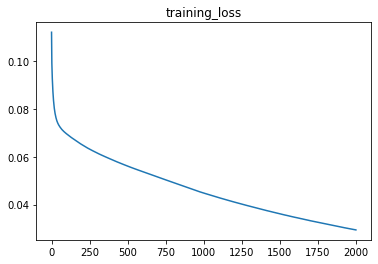

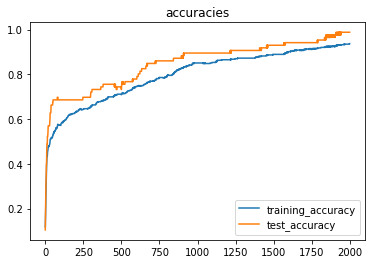

In [187]:
plt.figure(1)
plt.plot(training_losses, label='training_loss')
plt.title('training_loss')

plt.figure(2)
plt.plot(training_accuracy, label='training_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()
plt.title('accuracies')


In [162]:
torch.save(net.state_dict(), 'ttt-model.pt')

In [190]:
reset_net()
training_losses, training_accuracy, test_accuracies = training_loop(learning_rate=1e-4)

epoch: 0, tr_loss: 0.15336498247387884
tr_acc: 0.11057692307692316, test_acc: 0.08139534883720931
epoch: 1, tr_loss: 0.14267650475868823
tr_acc: 0.11298076923076932, test_acc: 0.10465116279069767
epoch: 2, tr_loss: 0.1344583964226051
tr_acc: 0.14663461538461542, test_acc: 0.15116279069767438
epoch: 3, tr_loss: 0.1280016798633509
tr_acc: 0.15384615384615385, test_acc: 0.18604651162790692
epoch: 4, tr_loss: 0.12285814094894489
tr_acc: 0.1610576923076923, test_acc: 0.1976744186046511
epoch: 5, tr_loss: 0.11870950470284486
tr_acc: 0.16826923076923073, test_acc: 0.20930232558139528
epoch: 6, tr_loss: 0.1153224311285437
tr_acc: 0.17548076923076916, test_acc: 0.1976744186046511
epoch: 7, tr_loss: 0.11255373782478277
tr_acc: 0.18509615384615374, test_acc: 0.20930232558139528
epoch: 8, tr_loss: 0.11027496098540718
tr_acc: 0.1874999999999999, test_acc: 0.20930232558139528
epoch: 9, tr_loss: 0.10838275689345139
tr_acc: 0.18509615384615374, test_acc: 0.1976744186046511
epoch: 10, tr_loss: 0.106798

epoch: 84, tr_loss: 0.09029401364163135
tr_acc: 0.36057692307692235, test_acc: 0.37209302325581406
epoch: 85, tr_loss: 0.09019740313613928
tr_acc: 0.36057692307692235, test_acc: 0.37209302325581406
epoch: 86, tr_loss: 0.09010125081448886
tr_acc: 0.36057692307692235, test_acc: 0.37209302325581406
epoch: 87, tr_loss: 0.09000576259747436
tr_acc: 0.36057692307692235, test_acc: 0.37209302325581406
epoch: 88, tr_loss: 0.08991098876755965
tr_acc: 0.3629807692307685, test_acc: 0.37209302325581406
epoch: 89, tr_loss: 0.08981692165924382
tr_acc: 0.36538461538461464, test_acc: 0.37209302325581406
epoch: 90, tr_loss: 0.08972327615349335
tr_acc: 0.36538461538461464, test_acc: 0.37209302325581406
epoch: 91, tr_loss: 0.08963037548192712
tr_acc: 0.3629807692307685, test_acc: 0.37209302325581406
epoch: 92, tr_loss: 0.08953824583799218
tr_acc: 0.37019230769230693, test_acc: 0.37209302325581406
epoch: 93, tr_loss: 0.08944704119438449
tr_acc: 0.37019230769230693, test_acc: 0.37209302325581406
epoch: 94, t

epoch: 168, tr_loss: 0.08404229183752948
tr_acc: 0.4278846153846144, test_acc: 0.4651162790697677
epoch: 169, tr_loss: 0.08398506819951136
tr_acc: 0.4278846153846144, test_acc: 0.4651162790697677
epoch: 170, tr_loss: 0.08392820057745734
tr_acc: 0.4278846153846144, test_acc: 0.4651162790697677
epoch: 171, tr_loss: 0.08387151769756414
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 172, tr_loss: 0.08381504981886016
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 173, tr_loss: 0.08375843267780371
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 174, tr_loss: 0.08370172953268942
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 175, tr_loss: 0.08364541292226368
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 176, tr_loss: 0.08358940305725596
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 177, tr_loss: 0.08353372044467292
tr_acc: 0.43028846153846056, test_acc: 0.4651162790697677
epoch: 178, t

epoch: 252, tr_loss: 0.08012805114356941
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 253, tr_loss: 0.08009158526189045
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 254, tr_loss: 0.0800553885951208
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 255, tr_loss: 0.08001944086908436
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 256, tr_loss: 0.07998371270234478
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 257, tr_loss: 0.07994797454179767
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 258, tr_loss: 0.0799122685029243
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 259, tr_loss: 0.07987678600833399
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 260, tr_loss: 0.07984134781425097
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 261, tr_loss: 0.07980609748763255
tr_acc: 0.47836538461538347, test_acc: 0.5232558139534887
epoch: 262, 

epoch: 337, tr_loss: 0.07750669298156236
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 338, tr_loss: 0.07748157634005803
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 339, tr_loss: 0.07745648201447555
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 340, tr_loss: 0.0774313198098053
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 341, tr_loss: 0.07740623072291225
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 342, tr_loss: 0.07738125437082576
tr_acc: 0.49278846153846034, test_acc: 0.5581395348837214
epoch: 343, tr_loss: 0.07735624930892988
tr_acc: 0.49278846153846034, test_acc: 0.5581395348837214
epoch: 344, tr_loss: 0.07733131658572415
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 345, tr_loss: 0.07730648390805493
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 346, tr_loss: 0.07728177673505765
tr_acc: 0.4903846153846142, test_acc: 0.5581395348837214
epoch: 347, tr_loss

epoch: 421, tr_loss: 0.07568659444447029
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 422, tr_loss: 0.0756682556238957
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 423, tr_loss: 0.07564997991833548
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 424, tr_loss: 0.07563169373987386
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 425, tr_loss: 0.07561343245638107
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 426, tr_loss: 0.07559524352948828
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 427, tr_loss: 0.0755771212458897
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 428, tr_loss: 0.07555909886454729
tr_acc: 0.4999999999999988, test_acc: 0.5465116279069772
epoch: 429, tr_loss: 0.07554113558189082
tr_acc: 0.4999999999999988, test_acc: 0.5465116279069772
epoch: 430, tr_loss: 0.07552328821755228
tr_acc: 0.49759615384615263, test_acc: 0.5465116279069772
epoch: 431, tr

epoch: 506, tr_loss: 0.07431391475704288
tr_acc: 0.5216346153846141, test_acc: 0.534883720930233
epoch: 507, tr_loss: 0.07429972089952434
tr_acc: 0.5216346153846141, test_acc: 0.534883720930233
epoch: 508, tr_loss: 0.07428558571980554
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 509, tr_loss: 0.07427149386897394
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 510, tr_loss: 0.07425743968297649
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 511, tr_loss: 0.07424342532892916
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 512, tr_loss: 0.07422948934925855
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 513, tr_loss: 0.07421555508895276
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 514, tr_loss: 0.07420165517564428
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 515, tr_loss: 0.07418779855540308
tr_acc: 0.5240384615384602, test_acc: 0.534883720930233
epoch: 516, tr_loss: 0.0741739

epoch: 591, tr_loss: 0.07323299724465382
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 592, tr_loss: 0.07322158940727469
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 593, tr_loss: 0.0732102242361109
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 594, tr_loss: 0.07319890612807982
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 595, tr_loss: 0.07318764616502452
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 596, tr_loss: 0.07317642536676996
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 597, tr_loss: 0.07316519957608898
tr_acc: 0.5336538461538448, test_acc: 0.5465116279069772
epoch: 598, tr_loss: 0.07315401618745038
tr_acc: 0.536057692307691, test_acc: 0.5465116279069772
epoch: 599, tr_loss: 0.07314287329343361
tr_acc: 0.536057692307691, test_acc: 0.5465116279069772
epoch: 600, tr_loss: 0.0731317353157255
tr_acc: 0.536057692307691, test_acc: 0.5465116279069772
epoch: 601, tr_loss: 0.07

epoch: 675, tr_loss: 0.07236902494556631
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 676, tr_loss: 0.07235977397515223
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 677, tr_loss: 0.07235055432941484
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 678, tr_loss: 0.07234139897180004
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 679, tr_loss: 0.07233224012620317
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 680, tr_loss: 0.07232311641564597
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 681, tr_loss: 0.07231400118997465
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 682, tr_loss: 0.07230489469545251
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 683, tr_loss: 0.072295821186764
tr_acc: 0.5504807692307678, test_acc: 0.5465116279069772
epoch: 684, tr_loss: 0.07228675012279726
tr_acc: 0.552884615384614, test_acc: 0.5465116279069772
epoch: 685, tr_loss: 0.

epoch: 761, tr_loss: 0.07163552934071046
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 762, tr_loss: 0.07162782529261534
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 763, tr_loss: 0.07162013276963697
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 764, tr_loss: 0.07161243160953751
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 765, tr_loss: 0.07160470784247784
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 766, tr_loss: 0.07159704308455381
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 767, tr_loss: 0.07158940491857589
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 768, tr_loss: 0.07158176781824575
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 769, tr_loss: 0.07157407061626704
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 770, tr_loss: 0.0715663932765332
tr_acc: 0.5576923076923063, test_acc: 0.5465116279069772
epoch: 771, tr_loss: 

epoch: 845, tr_loss: 0.07102098480278914
tr_acc: 0.5673076923076908, test_acc: 0.5581395348837214
epoch: 846, tr_loss: 0.07101401778457399
tr_acc: 0.5673076923076908, test_acc: 0.5581395348837214
epoch: 847, tr_loss: 0.07100705878558354
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 848, tr_loss: 0.071000101917889
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 849, tr_loss: 0.07099318042254224
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 850, tr_loss: 0.07098624399916915
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 851, tr_loss: 0.0709793358333767
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 852, tr_loss: 0.07097243112422377
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 853, tr_loss: 0.07096552689864227
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 854, tr_loss: 0.07095863416235758
tr_acc: 0.569711538461537, test_acc: 0.5581395348837214
epoch: 855, tr_loss: 0.07095173

epoch: 929, tr_loss: 0.07046422318895704
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 930, tr_loss: 0.07045804515767555
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 931, tr_loss: 0.07045189129600589
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 932, tr_loss: 0.07044575542945841
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 933, tr_loss: 0.07043961655850021
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 934, tr_loss: 0.07043347941138423
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 935, tr_loss: 0.0704273291048594
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 936, tr_loss: 0.07042120702009504
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 937, tr_loss: 0.07041502765003733
tr_acc: 0.5673076923076908, test_acc: 0.5697674418604656
epoch: 938, tr_loss: 0.07040892258429755
tr_acc: 0.569711538461537, test_acc: 0.5697674418604656
epoch: 939, tr_loss: 0

epoch: 1013, tr_loss: 0.06997313400587202
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1014, tr_loss: 0.06996760849590195
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1015, tr_loss: 0.06996207460850618
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1016, tr_loss: 0.06995658140378791
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1017, tr_loss: 0.06995104616866091
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1018, tr_loss: 0.06994556543829215
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1019, tr_loss: 0.06994003201655755
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1020, tr_loss: 0.06993457233945195
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1021, tr_loss: 0.0699290819197464
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1022, tr_loss: 0.06992360228636803
tr_acc: 0.5721153846153831, test_acc: 0.5697674418604656
epoch: 1023

epoch: 1097, tr_loss: 0.06952449688777472
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1098, tr_loss: 0.06951937536583641
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1099, tr_loss: 0.06951423635473478
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1100, tr_loss: 0.06950909601828947
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1101, tr_loss: 0.06950398677369
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1102, tr_loss: 0.06949884447161682
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1103, tr_loss: 0.06949374377011101
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1104, tr_loss: 0.06948864883116368
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1105, tr_loss: 0.06948351831838052
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1106, tr_loss: 0.06947843597019807
tr_acc: 0.5745192307692293, test_acc: 0.5697674418604656
epoch: 1107, 

epoch: 1181, tr_loss: 0.06910113049133755
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1182, tr_loss: 0.06909617531793916
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1183, tr_loss: 0.06909122415639168
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1184, tr_loss: 0.06908626897851573
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1185, tr_loss: 0.06908135173860223
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1186, tr_loss: 0.06907639250410001
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1187, tr_loss: 0.06907146355549161
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1188, tr_loss: 0.06906653364421801
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1189, tr_loss: 0.0690615906317432
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1190, tr_loss: 0.06905666688600416
tr_acc: 0.5745192307692293, test_acc: 0.5813953488372098
epoch: 1191

epoch: 1265, tr_loss: 0.06868659836562496
tr_acc: 0.5769230769230754, test_acc: 0.5813953488372098
epoch: 1266, tr_loss: 0.06868170109541658
tr_acc: 0.5769230769230754, test_acc: 0.5813953488372098
epoch: 1267, tr_loss: 0.06867682254120995
tr_acc: 0.5769230769230754, test_acc: 0.5813953488372098
epoch: 1268, tr_loss: 0.068671944595945
tr_acc: 0.5769230769230754, test_acc: 0.5813953488372098
epoch: 1269, tr_loss: 0.0686670901217999
tr_acc: 0.5769230769230754, test_acc: 0.5813953488372098
epoch: 1270, tr_loss: 0.0686622202808324
tr_acc: 0.5793269230769216, test_acc: 0.5813953488372098
epoch: 1271, tr_loss: 0.06865733661330659
tr_acc: 0.5793269230769216, test_acc: 0.5813953488372098
epoch: 1272, tr_loss: 0.06865245853371635
tr_acc: 0.5793269230769216, test_acc: 0.5813953488372098
epoch: 1273, tr_loss: 0.06864757483037046
tr_acc: 0.5793269230769216, test_acc: 0.5813953488372098
epoch: 1274, tr_loss: 0.06864268462567666
tr_acc: 0.5793269230769216, test_acc: 0.5813953488372098
epoch: 1275, t

epoch: 1349, tr_loss: 0.0682818103277196
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1350, tr_loss: 0.06827714142407497
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1351, tr_loss: 0.06827244788515736
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1352, tr_loss: 0.06826771569635291
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1353, tr_loss: 0.06826302252011374
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1354, tr_loss: 0.06825828304191911
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1355, tr_loss: 0.06825355812011719
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1356, tr_loss: 0.06824879612003522
tr_acc: 0.5769230769230754, test_acc: 0.5697674418604656
epoch: 1357, tr_loss: 0.06824409685885674
tr_acc: 0.5793269230769216, test_acc: 0.5697674418604656
epoch: 1358, tr_loss: 0.06823937372805977
tr_acc: 0.5793269230769216, test_acc: 0.5697674418604656
epoch: 1359

epoch: 1433, tr_loss: 0.06789177219168499
tr_acc: 0.58653846153846, test_acc: 0.5813953488372098
epoch: 1434, tr_loss: 0.06788713781637713
tr_acc: 0.58653846153846, test_acc: 0.5813953488372098
epoch: 1435, tr_loss: 0.06788257892745052
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1436, tr_loss: 0.0678779969838126
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1437, tr_loss: 0.06787341874531616
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1438, tr_loss: 0.06786884108218008
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1439, tr_loss: 0.06786425876914735
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1440, tr_loss: 0.06785969118041422
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1441, tr_loss: 0.06785510945617443
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1442, tr_loss: 0.06785054076373431
tr_acc: 0.5889423076923062, test_acc: 0.5813953488372098
epoch: 1443, tr

epoch: 1517, tr_loss: 0.06751362839042065
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1518, tr_loss: 0.06750930092396001
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1519, tr_loss: 0.06750491195215055
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1520, tr_loss: 0.06750051999384032
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1521, tr_loss: 0.06749619669818249
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1522, tr_loss: 0.06749181369489715
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1523, tr_loss: 0.067487452550827
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1524, tr_loss: 0.06748304622865718
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1525, tr_loss: 0.06747865547032027
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1526, tr_loss: 0.0674742966523179
tr_acc: 0.5937499999999984, test_acc: 0.5697674418604656
epoch: 1527, 

epoch: 1601, tr_loss: 0.06715027936689483
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1602, tr_loss: 0.06714597240296338
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1603, tr_loss: 0.06714173412407169
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1604, tr_loss: 0.06713744279561348
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1605, tr_loss: 0.06713314669188833
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1606, tr_loss: 0.06712883686011015
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1607, tr_loss: 0.06712458147935998
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1608, tr_loss: 0.06712027603330518
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1609, tr_loss: 0.06711596389336939
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1610, tr_loss: 0.06711171229835597
tr_acc: 0.5985576923076907, test_acc: 0.593023255813954
epoch: 1611, tr_loss

epoch: 1685, tr_loss: 0.06679590993175775
tr_acc: 0.5961538461538446, test_acc: 0.593023255813954
epoch: 1686, tr_loss: 0.06679178755103546
tr_acc: 0.5961538461538446, test_acc: 0.593023255813954
epoch: 1687, tr_loss: 0.06678766190844516
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1688, tr_loss: 0.06678345219608246
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1689, tr_loss: 0.06677935598641996
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1690, tr_loss: 0.06677522154327904
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1691, tr_loss: 0.06677101912926167
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1692, tr_loss: 0.06676691489365807
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1693, tr_loss: 0.06676276873958369
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1694, tr_loss: 0.06675864001646498
tr_acc: 0.5985576923076907, test_acc: 0.6046511627906982
epoch: 1695,

epoch: 1769, tr_loss: 0.06645611467851832
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1770, tr_loss: 0.06645209153961888
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1771, tr_loss: 0.06644806800893714
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1772, tr_loss: 0.06644405558920251
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1773, tr_loss: 0.06644001556560394
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1774, tr_loss: 0.06643600484284645
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1775, tr_loss: 0.0664320262216139
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1776, tr_loss: 0.06642803946026381
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1777, tr_loss: 0.066424028887503
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1778, tr_loss: 0.06642005950561719
tr_acc: 0.5937499999999984, test_acc: 0.6046511627906982
epoch: 1779, 

epoch: 1853, tr_loss: 0.06612306583422017
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1854, tr_loss: 0.06611905046156606
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1855, tr_loss: 0.06611506282262365
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1856, tr_loss: 0.06611112999514891
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1857, tr_loss: 0.06610714723445614
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1858, tr_loss: 0.06610319605813574
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1859, tr_loss: 0.06609923166643752
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1860, tr_loss: 0.06609525541604783
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1861, tr_loss: 0.06609124447836967
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 1862, tr_loss: 0.06608732910423824
tr_acc: 0.5961538461538446, test_acc: 0.6046511627906982
epoch: 186

epoch: 1937, tr_loss: 0.06579408250623744
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1938, tr_loss: 0.0657902338806217
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1939, tr_loss: 0.06578638027153486
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1940, tr_loss: 0.06578250016900711
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1941, tr_loss: 0.06577868212032345
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1942, tr_loss: 0.06577478859645243
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1943, tr_loss: 0.06577095269816571
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1944, tr_loss: 0.06576712482581988
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1945, tr_loss: 0.06576327691212867
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1946, tr_loss: 0.06575944124219506
tr_acc: 0.5937499999999984, test_acc: 0.593023255813954
epoch: 1947, tr_loss:

Text(0.5, 1.0, 'accuracies')

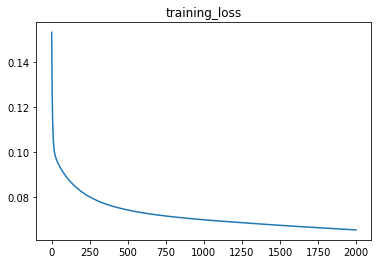

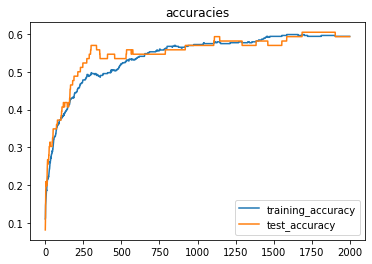

In [191]:
# with lr = 1e-4

plt.figure(1)
plt.plot(training_losses, label='training_loss')
plt.title('training_loss')

plt.figure(2)
plt.plot(training_accuracy, label='training_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()
plt.title('accuracies')


epoch: 0, tr_loss: 0.09875940148217174
tr_acc: 0.1610576923076923, test_acc: 0.1976744186046511
epoch: 1, tr_loss: 0.09343211073428388
tr_acc: 0.28605769230769185, test_acc: 0.2906976744186046
epoch: 2, tr_loss: 0.08982654626911075
tr_acc: 0.38701923076922995, test_acc: 0.313953488372093
epoch: 3, tr_loss: 0.08710734645585312
tr_acc: 0.4158653846153837, test_acc: 0.32558139534883723
epoch: 4, tr_loss: 0.08488561367042931
tr_acc: 0.42307692307692213, test_acc: 0.33720930232558144
epoch: 5, tr_loss: 0.08298367131143232
tr_acc: 0.4495192307692297, test_acc: 0.34883720930232565
epoch: 6, tr_loss: 0.08134664252149656
tr_acc: 0.4591346153846143, test_acc: 0.36046511627906985
epoch: 7, tr_loss: 0.07993338308118003
tr_acc: 0.4687499999999989, test_acc: 0.38372093023255827
epoch: 8, tr_loss: 0.07871364471681688
tr_acc: 0.49278846153846034, test_acc: 0.4186046511627909
epoch: 9, tr_loss: 0.0776491696283651
tr_acc: 0.5096153846153834, test_acc: 0.4418604651162793
epoch: 10, tr_loss: 0.07670336908

epoch: 86, tr_loss: 0.05816112183562766
tr_acc: 0.7091346153846134, test_acc: 0.6627906976744192
epoch: 87, tr_loss: 0.05804231080177343
tr_acc: 0.7115384615384596, test_acc: 0.6744186046511634
epoch: 88, tr_loss: 0.05790669912172374
tr_acc: 0.7139423076923057, test_acc: 0.6860465116279076
epoch: 89, tr_loss: 0.057777969837143985
tr_acc: 0.7163461538461519, test_acc: 0.6860465116279076
epoch: 90, tr_loss: 0.057659585884651345
tr_acc: 0.7163461538461519, test_acc: 0.6860465116279076
epoch: 91, tr_loss: 0.05752770506940296
tr_acc: 0.7163461538461519, test_acc: 0.6860465116279076
epoch: 92, tr_loss: 0.057410334039909326
tr_acc: 0.7163461538461519, test_acc: 0.6860465116279076
epoch: 93, tr_loss: 0.057277871887401056
tr_acc: 0.7211538461538441, test_acc: 0.6860465116279076
epoch: 94, tr_loss: 0.05715993476937559
tr_acc: 0.7211538461538441, test_acc: 0.6860465116279076
epoch: 95, tr_loss: 0.05703746686720896
tr_acc: 0.7307692307692287, test_acc: 0.6860465116279076
epoch: 96, tr_loss: 0.0569

epoch: 170, tr_loss: 0.048279396424802015
tr_acc: 0.7956730769230747, test_acc: 0.7674418604651171
epoch: 171, tr_loss: 0.048193252221748376
tr_acc: 0.7956730769230747, test_acc: 0.7674418604651171
epoch: 172, tr_loss: 0.04805668104969435
tr_acc: 0.7956730769230747, test_acc: 0.7674418604651171
epoch: 173, tr_loss: 0.047979780253137094
tr_acc: 0.7980769230769208, test_acc: 0.7674418604651171
epoch: 174, tr_loss: 0.04786209659841218
tr_acc: 0.7980769230769208, test_acc: 0.7674418604651171
epoch: 175, tr_loss: 0.047735490015139256
tr_acc: 0.7980769230769208, test_acc: 0.7674418604651171
epoch: 176, tr_loss: 0.04767969580951519
tr_acc: 0.7980769230769208, test_acc: 0.7674418604651171
epoch: 177, tr_loss: 0.04754567639723134
tr_acc: 0.8004807692307669, test_acc: 0.7674418604651171
epoch: 178, tr_loss: 0.04742685746672443
tr_acc: 0.7980769230769208, test_acc: 0.7674418604651171
epoch: 179, tr_loss: 0.047366396864303044
tr_acc: 0.8004807692307669, test_acc: 0.7790697674418613
epoch: 180, tr_

epoch: 254, tr_loss: 0.04026252757019111
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 255, tr_loss: 0.0401844692868718
tr_acc: 0.8605769230769206, test_acc: 0.8604651162790707
epoch: 256, tr_loss: 0.04007904583984499
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 257, tr_loss: 0.03999409160034981
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 258, tr_loss: 0.039908171995753396
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 259, tr_loss: 0.03982647238808568
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 260, tr_loss: 0.039746266526960346
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 261, tr_loss: 0.039669768542248324
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 262, tr_loss: 0.03956831671446424
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 263, tr_loss: 0.0394802804492848
tr_acc: 0.8629807692307667, test_acc: 0.8604651162790707
epoch: 264, tr_loss

epoch: 338, tr_loss: 0.03392654529279051
tr_acc: 0.9134615384615358, test_acc: 0.8837209302325592
epoch: 339, tr_loss: 0.033843450600845516
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 340, tr_loss: 0.03377391035358483
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 341, tr_loss: 0.03373455907813665
tr_acc: 0.9134615384615358, test_acc: 0.8837209302325592
epoch: 342, tr_loss: 0.03364283000253362
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 343, tr_loss: 0.03358226452250021
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 344, tr_loss: 0.033532748425596566
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 345, tr_loss: 0.033442357954090084
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 346, tr_loss: 0.03337192480914661
tr_acc: 0.9158653846153819, test_acc: 0.8837209302325592
epoch: 347, tr_loss: 0.03335492225009005
tr_acc: 0.9182692307692281, test_acc: 0.8837209302325592
epoch: 348, tr_lo

epoch: 422, tr_loss: 0.0290183116857616
tr_acc: 0.9471153846153818, test_acc: 0.9069767441860476
epoch: 423, tr_loss: 0.028728650998975643
tr_acc: 0.949519230769228, test_acc: 0.9186046511627918
epoch: 424, tr_loss: 0.028948154897639477
tr_acc: 0.9471153846153818, test_acc: 0.9069767441860476
epoch: 425, tr_loss: 0.028620748604365743
tr_acc: 0.949519230769228, test_acc: 0.9069767441860476
epoch: 426, tr_loss: 0.028777121194882335
tr_acc: 0.9471153846153818, test_acc: 0.9069767441860476
epoch: 427, tr_loss: 0.028492144036135866
tr_acc: 0.949519230769228, test_acc: 0.9069767441860476
epoch: 428, tr_loss: 0.02865478281455581
tr_acc: 0.9471153846153818, test_acc: 0.9069767441860476
epoch: 429, tr_loss: 0.028421519684903036
tr_acc: 0.9471153846153818, test_acc: 0.9069767441860476
epoch: 430, tr_loss: 0.02859938039714155
tr_acc: 0.9447115384615357, test_acc: 0.8953488372093034
epoch: 431, tr_loss: 0.02842716666810494
tr_acc: 0.9519230769230741, test_acc: 0.930232558139536
epoch: 432, tr_loss

epoch: 506, tr_loss: 0.02486811869745838
tr_acc: 0.9639423076923048, test_acc: 0.9418604651162802
epoch: 507, tr_loss: 0.025377718447159112
tr_acc: 0.9591346153846125, test_acc: 0.9418604651162802
epoch: 508, tr_loss: 0.02468789615508847
tr_acc: 0.966346153846151, test_acc: 0.9534883720930244
epoch: 509, tr_loss: 0.0253363831635887
tr_acc: 0.9615384615384587, test_acc: 0.9418604651162802
epoch: 510, tr_loss: 0.024634349240631535
tr_acc: 0.966346153846151, test_acc: 0.9534883720930244
epoch: 511, tr_loss: 0.02516510558500438
tr_acc: 0.9615384615384587, test_acc: 0.9418604651162802
epoch: 512, tr_loss: 0.024379800628594215
tr_acc: 0.966346153846151, test_acc: 0.9534883720930244
epoch: 513, tr_loss: 0.024896377556825236
tr_acc: 0.9615384615384587, test_acc: 0.9418604651162802
epoch: 514, tr_loss: 0.024410187003853077
tr_acc: 0.966346153846151, test_acc: 0.9534883720930244
epoch: 515, tr_loss: 0.024932524726934316
tr_acc: 0.9615384615384587, test_acc: 0.9418604651162802
epoch: 516, tr_loss

epoch: 590, tr_loss: 0.021228375097472548
tr_acc: 0.9711538461538433, test_acc: 0.9534883720930244
epoch: 591, tr_loss: 0.022604074746945677
tr_acc: 0.966346153846151, test_acc: 0.9418604651162802
epoch: 592, tr_loss: 0.021141657040901103
tr_acc: 0.9711538461538433, test_acc: 0.9534883720930244
epoch: 593, tr_loss: 0.022856002433959813
tr_acc: 0.966346153846151, test_acc: 0.9418604651162802
epoch: 594, tr_loss: 0.021089105645772252
tr_acc: 0.9735576923076894, test_acc: 0.9651162790697686
epoch: 595, tr_loss: 0.022768346846882746
tr_acc: 0.966346153846151, test_acc: 0.9418604651162802
epoch: 596, tr_loss: 0.02104901303195778
tr_acc: 0.9735576923076894, test_acc: 0.9651162790697686
epoch: 597, tr_loss: 0.02255305528188519
tr_acc: 0.966346153846151, test_acc: 0.9418604651162802
epoch: 598, tr_loss: 0.020954460912085204
tr_acc: 0.9735576923076894, test_acc: 0.9651162790697686
epoch: 599, tr_loss: 0.02229902439816772
tr_acc: 0.966346153846151, test_acc: 0.9418604651162802
epoch: 600, tr_los

epoch: 674, tr_loss: 0.018608729415063884
tr_acc: 0.9759615384615355, test_acc: 0.9651162790697686
epoch: 675, tr_loss: 0.01997497695013477
tr_acc: 0.9687499999999971, test_acc: 0.9534883720930244
epoch: 676, tr_loss: 0.01858074609117467
tr_acc: 0.9783653846153817, test_acc: 0.9651162790697686
epoch: 677, tr_loss: 0.019894733428652837
tr_acc: 0.9711538461538433, test_acc: 0.9651162790697686
epoch: 678, tr_loss: 0.018615433188782712
tr_acc: 0.9759615384615355, test_acc: 0.9651162790697686
epoch: 679, tr_loss: 0.019632839527240816
tr_acc: 0.9711538461538433, test_acc: 0.9534883720930244
epoch: 680, tr_loss: 0.018906221547835108
tr_acc: 0.9735576923076894, test_acc: 0.9651162790697686
epoch: 681, tr_loss: 0.019556250924114654
tr_acc: 0.9711538461538433, test_acc: 0.9534883720930244
epoch: 682, tr_loss: 0.019252348614687564
tr_acc: 0.9711538461538433, test_acc: 0.9651162790697686
epoch: 683, tr_loss: 0.0192955043816115
tr_acc: 0.9759615384615355, test_acc: 0.9651162790697686
epoch: 684, tr

epoch: 758, tr_loss: 0.018309952297736007
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 759, tr_loss: 0.01657566231313887
tr_acc: 0.9783653846153817, test_acc: 0.9651162790697686
epoch: 760, tr_loss: 0.017994584337989537
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 761, tr_loss: 0.016329392853339623
tr_acc: 0.9783653846153817, test_acc: 0.9651162790697686
epoch: 762, tr_loss: 0.01753225697029848
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 763, tr_loss: 0.016029358673362207
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 764, tr_loss: 0.017155522229586474
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 765, tr_loss: 0.015957896694649552
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 766, tr_loss: 0.017479688427276686
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 767, tr_loss: 0.016510476348580248
tr_acc: 0.9759615384615355, test_acc: 0.9534883720930244
epoch: 768, 

epoch: 842, tr_loss: 0.015032005247681257
tr_acc: 0.983173076923074, test_acc: 0.988372093023257
epoch: 843, tr_loss: 0.015757754427725628
tr_acc: 0.9855769230769201, test_acc: 0.9767441860465128
epoch: 844, tr_loss: 0.014386308245006002
tr_acc: 0.983173076923074, test_acc: 0.988372093023257
epoch: 845, tr_loss: 0.015511679202833105
tr_acc: 0.9879807692307663, test_acc: 0.988372093023257
epoch: 846, tr_loss: 0.014250487140858383
tr_acc: 0.983173076923074, test_acc: 0.988372093023257
epoch: 847, tr_loss: 0.015648120493586673
tr_acc: 0.9855769230769201, test_acc: 0.988372093023257
epoch: 848, tr_loss: 0.014523394469646386
tr_acc: 0.983173076923074, test_acc: 0.988372093023257
epoch: 849, tr_loss: 0.015784139198680904
tr_acc: 0.9879807692307663, test_acc: 0.988372093023257
epoch: 850, tr_loss: 0.015131415389287917
tr_acc: 0.9807692307692278, test_acc: 0.9767441860465128
epoch: 851, tr_loss: 0.01603945143926048
tr_acc: 0.9855769230769201, test_acc: 0.9767441860465128
epoch: 852, tr_loss: 0

epoch: 926, tr_loss: 0.014388814942112032
tr_acc: 0.9903846153846124, test_acc: 1.000000000000001
epoch: 927, tr_loss: 0.014030296892787397
tr_acc: 0.9879807692307663, test_acc: 0.9767441860465128
epoch: 928, tr_loss: 0.014473253409680479
tr_acc: 0.9927884615384586, test_acc: 1.000000000000001
epoch: 929, tr_loss: 0.013697650411184164
tr_acc: 0.9879807692307663, test_acc: 0.988372093023257
epoch: 930, tr_loss: 0.013901468434806493
tr_acc: 0.9927884615384586, test_acc: 1.000000000000001
epoch: 931, tr_loss: 0.013537829510404177
tr_acc: 0.9903846153846124, test_acc: 0.988372093023257
epoch: 932, tr_loss: 0.013599041656142128
tr_acc: 0.9927884615384586, test_acc: 1.000000000000001
epoch: 933, tr_loss: 0.01360242974960084
tr_acc: 0.9903846153846124, test_acc: 0.988372093023257
epoch: 934, tr_loss: 0.01345723493851927
tr_acc: 0.9927884615384586, test_acc: 0.988372093023257
epoch: 935, tr_loss: 0.013929305311299135
tr_acc: 0.9879807692307663, test_acc: 0.988372093023257
epoch: 936, tr_loss: 

epoch: 1010, tr_loss: 0.012706548518158679
tr_acc: 0.9927884615384586, test_acc: 1.000000000000001
epoch: 1011, tr_loss: 0.01267121672082375
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1012, tr_loss: 0.01255507651092976
tr_acc: 0.9951923076923047, test_acc: 0.988372093023257
epoch: 1013, tr_loss: 0.012435464839514816
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1014, tr_loss: 0.01229518652689875
tr_acc: 0.9951923076923047, test_acc: 0.988372093023257
epoch: 1015, tr_loss: 0.012242429952843494
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1016, tr_loss: 0.012221973991752469
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1017, tr_loss: 0.012152340150071085
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1018, tr_loss: 0.0124539945430185
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1019, tr_loss: 0.012377587723816624
tr_acc: 0.9927884615384586, test_acc: 1.000000000000001
epoch: 1020, tr

epoch: 1094, tr_loss: 0.012321032342767399
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1095, tr_loss: 0.012182985576845778
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1096, tr_loss: 0.011391397819562154
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1097, tr_loss: 0.011887148569188015
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1098, tr_loss: 0.011361337354453728
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1099, tr_loss: 0.01148617053443629
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1100, tr_loss: 0.011364723980967438
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1101, tr_loss: 0.010785868637797713
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1102, tr_loss: 0.01118015652166203
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1103, tr_loss: 0.010970689365701848
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1104,

epoch: 1178, tr_loss: 0.011308190028033157
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1179, tr_loss: 0.01028454724039945
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1180, tr_loss: 0.010282306421336573
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1181, tr_loss: 0.01003574207746939
tr_acc: 0.9951923076923047, test_acc: 1.000000000000001
epoch: 1182, tr_loss: 0.009939993446935717
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1183, tr_loss: 0.010111081989145114
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1184, tr_loss: 0.010488728176894191
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1185, tr_loss: 0.011045148491225867
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1186, tr_loss: 0.011116286359258367
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1187, tr_loss: 0.010788444138457778
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1188,

epoch: 1262, tr_loss: 0.009507752859532878
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1263, tr_loss: 0.009659815192068114
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1264, tr_loss: 0.009295586721726487
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1265, tr_loss: 0.008978985230686918
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1266, tr_loss: 0.009276705247639962
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1267, tr_loss: 0.009129802370667819
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1268, tr_loss: 0.009730102125384011
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1269, tr_loss: 0.009231776759686627
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1270, tr_loss: 0.009881676711721896
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1271, tr_loss: 0.00907853049172375
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1272, t

epoch: 1346, tr_loss: 0.00832695425238994
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1347, tr_loss: 0.00850608717099441
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1348, tr_loss: 0.008590238859771764
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1349, tr_loss: 0.008373607981551548
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1350, tr_loss: 0.00911905334676423
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1351, tr_loss: 0.00849622067975221
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1352, tr_loss: 0.01034879194412498
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1353, tr_loss: 0.008538883761502811
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1354, tr_loss: 0.009607488054406038
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1355, tr_loss: 0.008258737403873694
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1356, tr_loss: 

epoch: 1430, tr_loss: 0.007762814144371081
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1431, tr_loss: 0.00815761168464982
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1432, tr_loss: 0.007983900717870437
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1433, tr_loss: 0.008242680015218166
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1434, tr_loss: 0.008267417874146935
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1435, tr_loss: 0.008632076096126606
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1436, tr_loss: 0.008219969250813641
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1437, tr_loss: 0.009723159322535284
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1438, tr_loss: 0.00758172735885846
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1439, tr_loss: 0.008782985240171775
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1440, tr_loss

epoch: 1514, tr_loss: 0.008687103106869744
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1515, tr_loss: 0.0072183699976449125
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1516, tr_loss: 0.008415305132495207
tr_acc: 0.9975961538461509, test_acc: 1.000000000000001
epoch: 1517, tr_loss: 0.006979563816247922
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1518, tr_loss: 0.007833851866822582
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1519, tr_loss: 0.006957024086099972
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1520, tr_loss: 0.007591706680824043
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1521, tr_loss: 0.007253767614271901
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1522, tr_loss: 0.007659931422564946
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1523, tr_loss: 0.007795795643967443
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1524, tr_l

epoch: 1598, tr_loss: 0.006552650854176212
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1599, tr_loss: 0.007381021268604221
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1600, tr_loss: 0.0065245590380632575
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1601, tr_loss: 0.007121492047610025
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1602, tr_loss: 0.0068055053321026855
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1603, tr_loss: 0.00718755086836609
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1604, tr_loss: 0.007730744047456452
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1605, tr_loss: 0.007912300594258478
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1606, tr_loss: 0.0074511029726216736
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1607, tr_loss: 0.008079791591556461
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1608, tr_lo

epoch: 1682, tr_loss: 0.006405345495155553
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1683, tr_loss: 0.0068103272345839405
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1684, tr_loss: 0.006229365337556095
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1685, tr_loss: 0.007819380686949165
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1686, tr_loss: 0.005960221815117762
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1687, tr_loss: 0.007649683912929435
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1688, tr_loss: 0.006021323439759163
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1689, tr_loss: 0.007590650253265398
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1690, tr_loss: 0.00614360786885999
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1691, tr_loss: 0.006815952993677519
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1692, tr_loss

epoch: 1766, tr_loss: 0.005825557345745509
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1767, tr_loss: 0.007374647047736985
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1768, tr_loss: 0.005733159389889741
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1769, tr_loss: 0.007856849320188083
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1770, tr_loss: 0.005849886309428816
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1771, tr_loss: 0.007086612684536075
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1772, tr_loss: 0.0057634992547089155
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1773, tr_loss: 0.0067648021174766
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1774, tr_loss: 0.005752252434341728
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1775, tr_loss: 0.006421704545223641
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1776, tr_loss:

epoch: 1850, tr_loss: 0.0054577267255808675
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1851, tr_loss: 0.0058854289097255855
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1852, tr_loss: 0.005445260127824157
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1853, tr_loss: 0.005756064576836736
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1854, tr_loss: 0.005562397554058406
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1855, tr_loss: 0.005605452203361399
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1856, tr_loss: 0.005799637027149197
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1857, tr_loss: 0.0054666932750338775
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1858, tr_loss: 0.006372442640055779
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1859, tr_loss: 0.005516166274796542
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1860, tr_l

epoch: 1934, tr_loss: 0.004985475782492494
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1935, tr_loss: 0.006774141132976954
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1936, tr_loss: 0.005044006689646407
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1937, tr_loss: 0.006857000218098202
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1938, tr_loss: 0.0050657401729949925
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1939, tr_loss: 0.005987981129412502
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1940, tr_loss: 0.005090047430432888
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1941, tr_loss: 0.00591218245430215
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1942, tr_loss: 0.005126069144772862
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1943, tr_loss: 0.0056015806249328885
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 1944, tr_los

epoch: 2018, tr_loss: 0.0060031722581907875
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2019, tr_loss: 0.005180065782427004
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2020, tr_loss: 0.006122051857381356
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2021, tr_loss: 0.0053299531167305325
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2022, tr_loss: 0.005727652273260625
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2023, tr_loss: 0.005099107758934015
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2024, tr_loss: 0.00568417607834048
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2025, tr_loss: 0.004930203909330328
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2026, tr_loss: 0.005703773494063242
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2027, tr_loss: 0.0048551476284746245
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2028, tr_lo

epoch: 2102, tr_loss: 0.006383356417910154
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2103, tr_loss: 0.004702600856070112
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2104, tr_loss: 0.006205737579176247
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2105, tr_loss: 0.004622864756269197
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2106, tr_loss: 0.00631144583516848
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2107, tr_loss: 0.00458347338301862
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2108, tr_loss: 0.00597421511737104
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2109, tr_loss: 0.004637228505788912
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2110, tr_loss: 0.006181795310357514
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2111, tr_loss: 0.004722518657637503
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2112, tr_loss: 0

epoch: 2186, tr_loss: 0.005403871562451129
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2187, tr_loss: 0.004502578307053152
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2188, tr_loss: 0.005510373851918232
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2189, tr_loss: 0.004537076870432285
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2190, tr_loss: 0.005415519192271086
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2191, tr_loss: 0.004871802806659477
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2192, tr_loss: 0.00522932170256004
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2193, tr_loss: 0.004787029803817578
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2194, tr_loss: 0.005022061027305498
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2195, tr_loss: 0.0047156651836093464
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2196, tr_loss

epoch: 2270, tr_loss: 0.0048219692602847666
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2271, tr_loss: 0.004260068135968491
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2272, tr_loss: 0.004685058563014676
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2273, tr_loss: 0.004615514187557541
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2274, tr_loss: 0.004544403976489356
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2275, tr_loss: 0.004498138334383839
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2276, tr_loss: 0.0045427004733238135
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2277, tr_loss: 0.004441754320186402
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2278, tr_loss: 0.0047738398303898465
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2279, tr_loss: 0.004287762964920082
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2280, tr_l

epoch: 2354, tr_loss: 0.004166759965301026
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2355, tr_loss: 0.006106409950706828
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2356, tr_loss: 0.003996657090283403
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2357, tr_loss: 0.00557663216281631
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2358, tr_loss: 0.003956670542160841
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2359, tr_loss: 0.005159792507513954
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2360, tr_loss: 0.003968342032994071
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2361, tr_loss: 0.005752236253276632
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2362, tr_loss: 0.0040371548732834476
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2363, tr_loss: 0.005552399131199937
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2364, tr_loss

epoch: 2438, tr_loss: 0.003789871706430859
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2439, tr_loss: 0.00441395284378114
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2440, tr_loss: 0.003905250337363841
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2441, tr_loss: 0.004042674669597964
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2442, tr_loss: 0.0043425318078964045
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2443, tr_loss: 0.0038637893056217673
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2444, tr_loss: 0.0050070895120790295
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2445, tr_loss: 0.003858302706318612
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2446, tr_loss: 0.00584466713091667
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2447, tr_loss: 0.0038899111373561584
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2448, tr_lo

epoch: 2522, tr_loss: 0.003626350914321217
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2523, tr_loss: 0.005500856554555455
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2524, tr_loss: 0.003698287907879534
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2525, tr_loss: 0.004814433186696149
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2526, tr_loss: 0.0037116923679325117
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2527, tr_loss: 0.004624934210159361
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2528, tr_loss: 0.00361559910019283
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2529, tr_loss: 0.004744578883359142
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2530, tr_loss: 0.0036063871250987104
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2531, tr_loss: 0.004568661040208939
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2532, tr_los

epoch: 2606, tr_loss: 0.004474758574080908
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2607, tr_loss: 0.0035186335124028426
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2608, tr_loss: 0.005015570397377951
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2609, tr_loss: 0.0035416066315379965
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2610, tr_loss: 0.004737101993249287
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2611, tr_loss: 0.003497660481850919
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2612, tr_loss: 0.0046824888386953895
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2613, tr_loss: 0.003437335619904702
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2614, tr_loss: 0.0049811640744267735
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2615, tr_loss: 0.0034800369814827425
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2616, tr

epoch: 2690, tr_loss: 0.004262000710486271
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2691, tr_loss: 0.0033042722761470384
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2692, tr_loss: 0.004232729030683489
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2693, tr_loss: 0.003380145343936211
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2694, tr_loss: 0.004060730783958911
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2695, tr_loss: 0.0034715758115803175
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2696, tr_loss: 0.003920282690439938
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2697, tr_loss: 0.0035589142190614277
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2698, tr_loss: 0.0037397159532282288
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2699, tr_loss: 0.0035616964825329394
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2700, tr

epoch: 2774, tr_loss: 0.0036272274615979645
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2775, tr_loss: 0.003443088686568588
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2776, tr_loss: 0.003648436802485287
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2777, tr_loss: 0.003608674754314752
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2778, tr_loss: 0.0035207364906874833
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2779, tr_loss: 0.003779153320080624
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2780, tr_loss: 0.0033950555984679697
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2781, tr_loss: 0.004814385720657395
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2782, tr_loss: 0.003368967201088081
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2783, tr_loss: 0.005547763941929306
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2784, tr_l

epoch: 2858, tr_loss: 0.004426145775771428
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2859, tr_loss: 0.0029893837483821423
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2860, tr_loss: 0.004514776647668514
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2861, tr_loss: 0.0031593266194949324
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2862, tr_loss: 0.003796671419107812
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2863, tr_loss: 0.0033063708987566155
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2864, tr_loss: 0.003258909335307599
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2865, tr_loss: 0.003495347358169128
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2866, tr_loss: 0.0030702767908923506
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2867, tr_loss: 0.004086309003888837
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2868, tr_

epoch: 2942, tr_loss: 0.005656889547795938
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2943, tr_loss: 0.0029764873038402536
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2944, tr_loss: 0.00479640672088303
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2945, tr_loss: 0.0029972201155032967
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2946, tr_loss: 0.0037698617662289707
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2947, tr_loss: 0.002985565709528042
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2948, tr_loss: 0.003063754597860679
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2949, tr_loss: 0.0032490611606940194
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2950, tr_loss: 0.0030374762308593563
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2951, tr_loss: 0.0036767388660686852
tr_acc: 0.999999999999997, test_acc: 1.000000000000001
epoch: 2952, tr

Text(0.5, 1.0, 'accuracies')

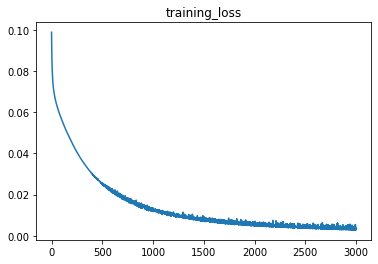

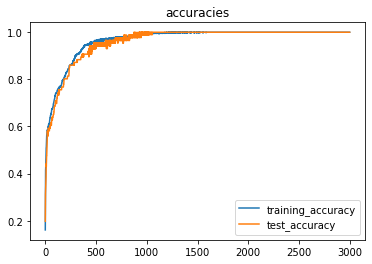

In [193]:
reset_net()
training_losses, training_accuracy, test_accuracies = training_loop(learning_rate=5e-3,
                                                                   epochs=3000)

# with lr = 5e-3, epochs=3000

plt.figure(1)
plt.plot(training_losses, label='training_loss')
plt.title('training_loss')

plt.figure(2)
plt.plot(training_accuracy, label='training_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()
plt.title('accuracies')

Text(0.5, 1.0, 'accuracies')

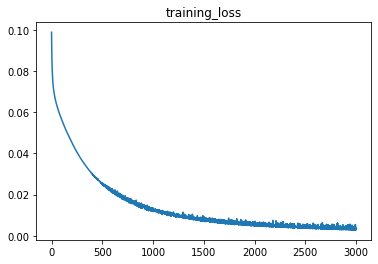

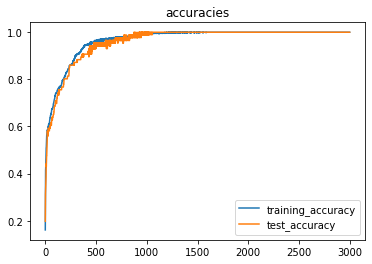

In [194]:
# with lr = 5e-3, epochs=3000

plt.figure(1)
plt.plot(training_losses, label='training_loss')
plt.title('training_loss')

plt.figure(2)
plt.plot(training_accuracy, label='training_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()
plt.title('accuracies')

In [195]:
torch.save(net.state_dict(), 'ttt-model-best.pt')

In [243]:
def play_student(model, state):
    """
    get next moves using the Neural Net
    """
    ss = simple_state(state)
    out = model(torch.tensor(ss, dtype=torch.float))
    move = torch.argmax(out)
#     print(move)
    return move


def simulate_nn_v_expert(model, trials=1):
    win_n, win_pro, win_d, win_e = 0, 0, 0, 0
    student = Player(Player.STUDENT, Entry.X)
    student.set_model(model)
    pro  = Player(Player.EXPERT, Entry.O)
    game = TicTacToe(student, pro)
    for i in range (trials): 
        t_start = time.time()
        log(game)
        while not game.game_ended:
            game.play()
        if game.winner == student:
            win_n += 1
        elif game.winner == pro:
            win_pro += 1
        elif game.winner == 'DRAW':
            win_d += 1
        elif game.winner == '-':
            win_e += 1
        else:
            print('something else')
        game.reset()
        
        if i%50 == 0:
            t_end = time.time()
            print(f'trial: {i}, total time taken: {round(t_end-t_start, 2)}s')
    print('simulate done')
    return win_n, win_pro, win_d, win_e


In [246]:
win_n, win_pro, win_d, win_e = simulate_nn_v_expert(net, 100)
print(f'student win: {win_n}, pro wins: {win_pro}')
print(f'draws: {win_d}, e wins: {win_e}')

trial: 0, total time taken: 3.27s
trial: 50, total time taken: 0.3s
simulate done
student win: 0, pro wins: 0
draws: 100, e wins: 0


In [252]:
def simulate_nn_v_rand(model, trials=1):
    win_n, win_r, win_d, win_e = 0, 0, 0, 0
    student = Player(Player.STUDENT, Entry.X)
    student.set_model(model)
    rand  = Player(Player.RANDOM, Entry.O)
    game = TicTacToe(student, rand)
    for i in range (trials): 
        t_start = time.time()
        log(game)
        while not game.game_ended:
            game.play()
        if game.winner == student:
            win_n += 1
        elif game.winner == rand:
            win_r += 1
        elif game.winner == 'DRAW':
            win_d += 1
        elif game.winner == '-':
            win_e += 1
        else:
            print('something else')
        game.reset()
        
        if i%50 == 0:
            t_end = time.time()
            print(f'trial: {i}, total time taken: {round(t_end-t_start, 2)}s')
    print('simulate done')
    print(f'student win: {win_n}, rand wins: {win_r}')
    print(f'draws: {win_d}, e wins: {win_e}')

simulate_nn_v_rand(net, 1000)



trial: 0, total time taken: 0.01s
trial: 50, total time taken: 0.0s
trial: 100, total time taken: 0.0s
trial: 150, total time taken: 0.0s
trial: 200, total time taken: 0.0s
trial: 250, total time taken: 0.0s
trial: 300, total time taken: 0.0s
trial: 350, total time taken: 0.0s
trial: 400, total time taken: 0.0s
trial: 450, total time taken: 0.0s
trial: 500, total time taken: 0.0s
trial: 550, total time taken: 0.0s
trial: 600, total time taken: 0.0s
trial: 650, total time taken: 0.0s
trial: 700, total time taken: 0.0s
trial: 750, total time taken: 0.0s
trial: 800, total time taken: 0.0s
trial: 850, total time taken: 0.0s
trial: 900, total time taken: 0.0s
trial: 950, total time taken: 0.0s
simulate done
student win: 907, rand wins: 13
draws: 80, e wins: 0
